# Import packages

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.models as models
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Subset, Dataset, DataLoader

import numpy as np
import h5py
import matplotlib.pyplot as plt
from PIL import Image
import argparse
from argparse import Namespace

import os
import random
from tqdm import tqdm

import tensorboard
from torchsummary import summary
from torch.utils.tensorboard import SummaryWriter

from resnet import resnet18, resnet34, resnet50
from datetime import datetime as dt

if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

In [3]:
device

device(type='cuda')

# Dataset

In [4]:
particle2idx = {
    '1fpv': 0,
    '1ss8': 1,
    '3j03': 2,
    '1ijg': 3,
    '3iyf': 4,
    '6ody': 5,
    '6sp2': 6,
    '6xs6': 7,
    '7dwz': 8,
    '7dx8': 9,
    '7dx9': 10
}

count2idx = {
    'single': 0,
    'double': 1,
    'triple': 2,
    'quadruple': 3
}

In [5]:
idx2particle = {
    0: '1fpv',
    2: '1ss8',
    2: '3j03',
    3: '1ijg',
    4: '3iyf',
    5: '6ody',
    6: '6sp2',
    7: '6xs6',
    8: '7dwz',
    9: '7dx8',
    10: '7dx9'
}

idx2count = {
    0: 'single',
    1: 'double',
    2: 'triple',
    3: 'quadruple'
}

In [6]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, root_dir, particles, counts, transform=None, seed=1234):
        self.root_dir = root_dir
        self.transform = transform

        self.count_labels = []
        self.particle_labels = []
        self.data = []

        for particle in particles:
            for count in counts:
                if count == 'single':
                    n = 4
                else:
                    n = 1
                data_dir = f'{self.root_dir}/SPI_{particle}_{str(n)}k_{count}_thumbnail.h5'

                # Load images as h5 files
                f = h5py.File(data_dir, 'r')
                dset_name = list(f.keys())[0]
                data = f[dset_name]
                data = [Image.fromarray(data[i]) for i in range(LENGTH * n)]
                data = [self.transform(data[i]) for i in range(LENGTH * n)]
                count_label = [count2idx[count]] * (LENGTH * n)
                particle_label = [particle2idx[particle]] * (LENGTH * n)
                self.data.extend(data)
                self.count_labels.extend(count_label)
                self.particle_labels.extend(particle_label)
        
        # Shuffle the data
        random.seed(seed)
        perm = list(range(len(self.data)))
        random.shuffle(perm)
        self.data = [self.data[i] for i in perm]
        self.count_labels = [self.count_labels[i] for i in perm]
        self.particle_labels = [self.particle_labels[i] for i in perm]

    def __len__(self):
        '''Denotes the total number of samples'''
        return len(self.data)

    def __getitem__(self, index):
        '''Generates one sample of data'''
        X = self.data[index]
        count = self.count_labels[index]
        particle = self.particle_labels[index]
        return X, count, particle

# Dataloader

In [7]:
def get_dataloaders(args, train_val_particles, test_particles, test_diff_particle=False):
    transform = transforms.Compose([transforms.CenterCrop(128),
                                    transforms.RandomVerticalFlip(p=0.5),
                                    transforms.RandomHorizontalFlip(p=0.5),
                                    transforms.ToTensor()])
    data_len = args.num_particles * 7000
    
    if not test_diff_particle:
        assert train_val_particles == test_particles
        dataset = CustomDataset(root_dir=args.root_dir,
                                particles=train_val_particles,
                                counts=COUNTS,
                                transform=transform)
        print(len(dataset))
        train_idx = list(range(0, int(data_len * 0.7)))
        valid_idx = list(range(int(data_len * 0.7), int(data_len * 0.8)))
        test_idx = list(range(int(data_len * 0.8), data_len))
        train_dataset = Subset(dataset, train_idx) 
        valid_dataset = Subset(dataset, valid_idx)
        test_dataset = Subset(dataset, test_idx)
    else:
        # Create train/valid/test datasets
        train_val_dataset = CustomDataset(root_dir=args.root_dir, 
                                          particles=train_val_particles,
                                          counts=COUNTS,
                                          transform=transform)
        train_idx = list(range(0, 7000))
        valid_idx = list(range(7000, 8000))
        train_dataset = Subset(train_val_dataset, train_idx) 
        valid_dataset = Subset(train_val_dataset, valid_idx)
        test_dataset = CustomDataset(root_dir=args.root_dir, 
                                    particles=test_particles,
                                    counts=COUNTS,
                                    transform=transform)
        
        assert train_dataset.__getitem__(0)[0].shape == torch.Size([1, 128, 128])
        assert valid_dataset.__getitem__(0)[0].shape == torch.Size([1, 128, 128])
        assert test_dataset.__getitem__(0)[0].shape == torch.Size([1, 128, 128])

    # Create train/valid/test dataloaders
    train_dataloader = DataLoader(dataset=train_dataset,
                                  batch_size=args.batch_size,
                                  shuffle=args.shuffle, 
                                  num_workers=args.num_workers)
    valid_dataloader = DataLoader(dataset=valid_dataset,
                                  batch_size=args.batch_size,
                                  shuffle=args.shuffle, 
                                  num_workers=args.num_workers)
    test_dataloader = DataLoader(dataset=test_dataset, 
                                 batch_size=args.batch_size, 
                                 shuffle=args.shuffle, 
                                 num_workers=args.num_workers)
    return train_dataloader, valid_dataloader, test_dataloader

# Utils

In [8]:
def sp_noise(image,prob):
    '''
    Add salt and pepper noise to image
    prob: Probability of the noise
    '''
    output = np.zeros(image.shape,np.uint8)
    thres = 1 - prob 
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            rdn = random.random()
            if rdn < prob:
                output[i][j] = 0
            elif rdn > thres:
                output[i][j] = 255
            else:
                output[i][j] = image[i][j]
    return output

In [32]:
def read_thumbnails(fname):
    f = h5py.File(fname, 'r')
    dset_name = list(f.keys())[0]
    print("Check the datasets keys: " + str(list(f.keys())))
    
    dset = f[dset_name]
    print("Check the shape of the dataset: " + str(dset.shape))
    
    print(len(dset))
    w=20
    h=20
    fig=plt.figure(figsize=(15, 15))
    columns = 4
    rows = 5
    for i in range(1, columns*rows +1):
        img = dset[5* i]
        fig.add_subplot(rows, columns, i)
        plt.imshow(img, vmin=0, vmax=10)
    plt.show()

### Combine two h5 files and save as new file

In [33]:
root_dir = './data/thumbnail'

In [28]:
particle = '1fpv'
filenames = [f'{root_dir}/SPI_{particle}_1k_single_thumbnail.h5',
             f'{root_dir}/SPI_{particle}_3k_single_thumbnail.h5']

dataset = []

for fname in filenames:
    f = h5py.File(fname,'r+')
    dset_name = list(f.keys())[0]
    dset = f[dset_name]
    dataset.extend(dset)

In [11]:
len(dataset)

4000

In [12]:
fout = h5py.File(f'{root_dir}/SPI_{particle}_4k_single_thumbnail.h5','w')
ds = fout.create_dataset('photons', (4000, 128, 130), dtype='float32')
for i in range(4000):
    ds[i,:,:] = dataset[i]
fout.close()

Check the datasets keys: ['photons']
Check the shape of the dataset: (4000, 128, 130)
4000


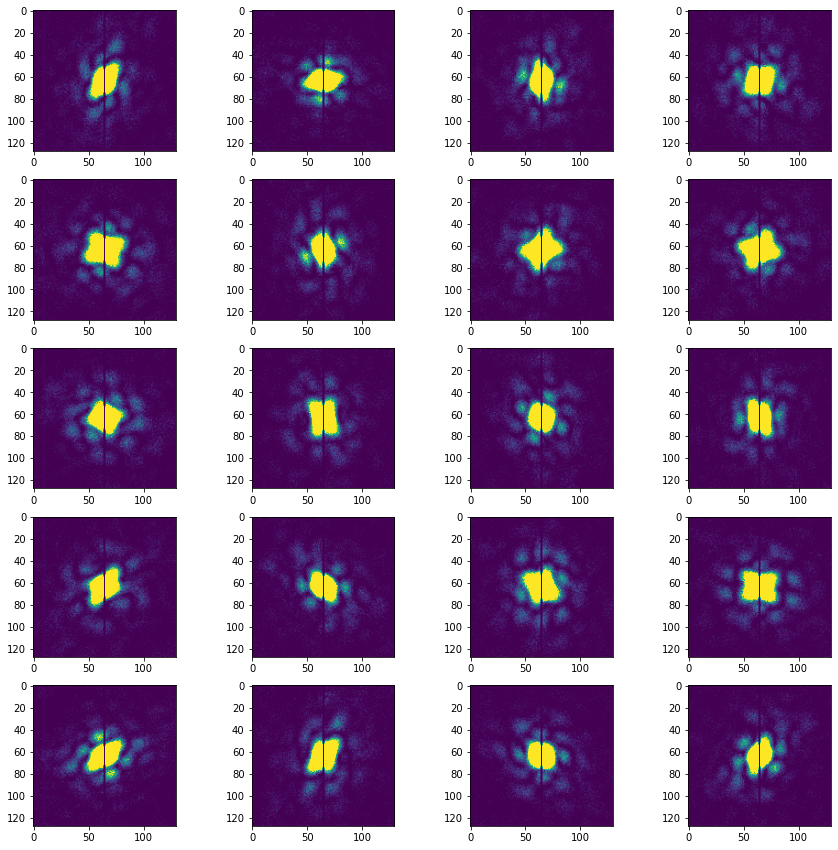

In [38]:
particle = '6xs6'
root_dir = './data/thumbnail'
image_dir = f'{root_dir}/SPI_{particle}_4k_single_thumbnail.h5'

read_thumbnails(image_dir)

# Models

## 3-layer Multi-output CNN (Late)

In [10]:
class MultiOutputCNN(nn.Module):
    def __init__(self, num_particles=11, num_counts=4, hidden_dim=8):
        super(MultiOutputCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, hidden_dim, 2, 2) # (8, 64, 64)
        self.conv2 = nn.Conv2d(hidden_dim, hidden_dim * 4, 4, 4) # (32, 16, 16)
        self.conv3 = nn.Conv2d(hidden_dim * 4, hidden_dim * 16, 4, 4) # (128, 4, 4)
        self.dropout1 = nn.Dropout(0.25)
        self.fc1 = nn.Linear(2048, num_counts)
        self.fc2 = nn.Linear(2048, num_particles)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.conv3(x)
        x = F.relu(x)
#         x = self.conv4(x)
#         x = F.relu(x)
#         x = self.conv5(x)
#         x = F.relu(x)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)

        y1 = self.fc1(x)
        y1 = F.log_softmax(y1, dim=1)
        y2 = self.fc2(x)
        y2 = F.log_softmax(y2, dim=1)
        return y1, y2

## 5-layer Multi-output CNN (Late)

In [27]:
class MultiOutputCNN(nn.Module):
    def __init__(self, num_particles=11, num_counts=4, hidden_dim=8):
        super(MultiOutputCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, hidden_dim, 2, 2) # (8, 64, 64)
        self.conv2 = nn.Conv2d(hidden_dim, hidden_dim * 2, 2, 2) # (16, 32, 32)
        self.conv3 = nn.Conv2d(hidden_dim * 2, hidden_dim * 4, 2, 2) # (32, 16, 16)
        self.conv4 = nn.Conv2d(hidden_dim * 4, hidden_dim * 8, 2, 2) # (64, 8, 8)
        self.conv5 = nn.Conv2d(hidden_dim * 8, hidden_dim * 16, 2, 2) # (128, 4, 4)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(2048, num_counts)
        self.fc2 = nn.Linear(2048, num_particles)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.conv3(x)
        x = F.relu(x)
        x = self.conv4(x)
        x = F.relu(x)
        x = self.conv5(x)
        x = F.relu(x)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)

        y1 = self.fc1(x)
        y1 = F.log_softmax(y1, dim=1)
        y2 = self.fc2(x)
        y2 = F.log_softmax(y2, dim=1)
        return y1, y2

## 10-layer Multi-output CNN (Late)

In [11]:
class MultiOutputCNN(nn.Module):
    def __init__(self, num_particles=11, num_counts=4, hidden_dim=8):
        super(MultiOutputCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, hidden_dim, 2, 2) # (8, 64, 64)
        self.conv2 = nn.Conv2d(hidden_dim, hidden_dim * 2, 2, 2) # (16, 32, 32)
        self.conv3 = nn.Conv2d(hidden_dim * 2, hidden_dim * 4, 2, 2) # (32, 16, 16)
        self.conv4 = nn.Conv2d(hidden_dim * 4, hidden_dim * 8, 2, 2) # (64, 8, 8)
        self.conv5 = nn.Conv2d(hidden_dim * 8, hidden_dim * 8, 2, 1) # (64, 7, 7)
        self.conv6 = nn.Conv2d(hidden_dim * 8, hidden_dim * 8, 2, 1) # (64, 6, 6)
        self.conv7 = nn.Conv2d(hidden_dim * 8, hidden_dim * 8, 2, 1) # (64, 5, 5)
        self.conv8 = nn.Conv2d(hidden_dim * 8, hidden_dim * 16, 1, 1) # (128, 5, 5)
        self.conv9 = nn.Conv2d(hidden_dim * 16, hidden_dim * 16, 2, 1) # (128, 4, 4)
        self.dropout1 = nn.Dropout(0.25)
        self.fc1 = nn.Linear(2048, num_counts)
        self.fc2 = nn.Linear(2048, num_particles)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.conv3(x)
        x = F.relu(x)
        x = self.conv4(x)
        x = F.relu(x)
        x = self.conv5(x)
        x = F.relu(x)
        x = self.conv6(x)
        x = F.relu(x)
        x = self.conv7(x)
        x = F.relu(x)
        x = self.conv8(x)
        x = F.relu(x)
        x = self.conv9(x)
        x = F.relu(x)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)

        y1 = self.fc1(x)
        y1 = F.log_softmax(y1, dim=1)
        y2 = self.fc2(x)
        y2 = F.log_softmax(y2, dim=1)
        return y1, y2

## 18-layer Multi-output CNN (Late)

In [62]:
class MultiOutputCNN(nn.Module):
    def __init__(self, num_particles=11, num_counts=4, hidden_dim=8):
        super(MultiOutputCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, hidden_dim, 2, 2) # (8, 64, 64)
        self.conv2 = nn.Conv2d(hidden_dim, hidden_dim * 2, 2, 2) # (16, 32, 32)
        self.conv3 = nn.Conv2d(hidden_dim * 2, hidden_dim * 4, 2, 2) # (32, 16, 16)
        self.conv4 = nn.Conv2d(hidden_dim * 4, hidden_dim * 4, 2, 1) # (32, 15, 15)
        self.conv5 = nn.Conv2d(hidden_dim * 4, hidden_dim * 4, 2, 1) # (32, 14, 14)
        self.conv6 = nn.Conv2d(hidden_dim * 4, hidden_dim * 4, 2, 1) # (32, 13, 13)
        self.conv7 = nn.Conv2d(hidden_dim * 4, hidden_dim * 4, 2, 1) # (32, 12, 12)
        self.conv8 = nn.Conv2d(hidden_dim * 4, hidden_dim * 4, 2, 1) # (32, 11, 11)
        self.conv9 = nn.Conv2d(hidden_dim * 4, hidden_dim * 4, 2, 1) # (32, 10, 10)
        self.conv10 = nn.Conv2d(hidden_dim * 4, hidden_dim * 4, 2, 1) # (32, 9, 9)
        self.conv11 = nn.Conv2d(hidden_dim * 4, hidden_dim * 8, 1, 1) # (64, 9, 9)
        self.conv12 = nn.Conv2d(hidden_dim * 8, hidden_dim * 8, 2, 1) # (64, 8, 8)
        self.conv13 = nn.Conv2d(hidden_dim * 8, hidden_dim * 8, 2, 1) # (64, 7, 7)
        self.conv14 = nn.Conv2d(hidden_dim * 8, hidden_dim * 8, 2, 1) # (64, 6, 6)
        self.conv15 = nn.Conv2d(hidden_dim * 8, hidden_dim * 8, 2, 1) # (64, 5, 5)
        self.conv16 = nn.Conv2d(hidden_dim * 8, hidden_dim * 16, 1, 1) # (128, 5, 5)
        self.conv17 = nn.Conv2d(hidden_dim * 16, hidden_dim * 16, 2, 1) # (128, 4, 4)
        self.dropout1 = nn.Dropout(0.25)
        self.fc1 = nn.Linear(2048, num_counts)
        self.fc2 = nn.Linear(2048, num_particles)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.conv3(x)
        x = F.relu(x)
        x = self.conv4(x)
        x = F.relu(x)
        x = self.conv5(x)
        x = F.relu(x)
        x = self.conv6(x)
        x = F.relu(x)
        x = self.conv7(x)
        x = F.relu(x)
        x = self.conv8(x)
        x = F.relu(x)
        x = self.conv9(x)
        x = F.relu(x)
        x = self.conv10(x)
        x = F.relu(x)
        x = self.conv11(x)
        x = F.relu(x)
        x = self.conv12(x)
        x = F.relu(x)
        x = self.conv13(x)
        x = F.relu(x)
        x = self.conv14(x)
        x = F.relu(x)
        x = self.conv15(x)
        x = F.relu(x)
        x = self.conv16(x)
        x = F.relu(x)
        x = self.conv17(x)
        x = F.relu(x)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)

        y1 = self.fc1(x)
        y1 = F.log_softmax(y1, dim=1)
        y2 = self.fc2(x)
        y2 = F.log_softmax(y2, dim=1)
        return y1, y2

## Multi-output CNN (Early)

In [32]:
class MultiOutputCNN(nn.Module):
    def __init__(self, num_particles=11, num_counts=4, hidden_dim=8):
        super(MultiOutputCNN, self).__init__()
        
        
        self.conv1 = nn.Conv2d(1, hidden_dim, 2, 2) # (8, 64, 64)
        self.conv2 = nn.Conv2d(hidden_dim, hidden_dim * 2, 2, 2) # (16, 32, 32)
        
        #Brached
        self.conv3_b1 = nn.Conv2d(hidden_dim * 2, hidden_dim * 4, 2, 2) # (32, 16, 16)
        self.conv4_b1 = nn.Conv2d(hidden_dim * 4, hidden_dim * 8, 2, 2) # (64, 8, 8)
        self.conv5_b1 = nn.Conv2d(hidden_dim * 8, hidden_dim * 8, 2, 1) # (64, 7, 7)
        self.conv6_b1 = nn.Conv2d(hidden_dim * 8, hidden_dim * 8, 2, 1) # (64, 6, 6)
        self.conv7_b1 = nn.Conv2d(hidden_dim * 8, hidden_dim * 8, 2, 1) # (64, 5, 5)
        self.conv8_b1 = nn.Conv2d(hidden_dim * 8, hidden_dim * 16, 1, 1) # (128, 5, 5)
        self.conv9_b1 = nn.Conv2d(hidden_dim * 16, hidden_dim * 16, 2, 1) # (128, 4, 4)
        self.dropout1_b1 = nn.Dropout(0.25)
        self.fc1_b1 = nn.Linear(2048, num_counts)
        
        self.conv3_b2 = nn.Conv2d(hidden_dim * 2, hidden_dim * 4, 2, 2) # (32, 16, 16)
        self.conv4_b2 = nn.Conv2d(hidden_dim * 4, hidden_dim * 8, 2, 2) # (64, 8, 8)
        self.conv5_b2 = nn.Conv2d(hidden_dim * 8, hidden_dim * 8, 2, 1) # (64, 7, 7)
        self.conv6_b2 = nn.Conv2d(hidden_dim * 8, hidden_dim * 8, 2, 1) # (64, 6, 6)
        self.conv7_b2 = nn.Conv2d(hidden_dim * 8, hidden_dim * 8, 2, 1) # (64, 5, 5)
        self.conv8_b2 = nn.Conv2d(hidden_dim * 8, hidden_dim * 16, 1, 1) # (128, 5, 5)
        self.conv9_b2 = nn.Conv2d(hidden_dim * 16, hidden_dim * 16, 2, 1) # (128, 4, 4)
        self.dropout1_b2 = nn.Dropout(0.25)
        self.fc1_b2 = nn.Linear(2048, num_particles)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        
        #Brached
        y1 = self.conv3_b1(x)
        y1 = F.relu(y1)
        y1 = self.conv4_b1(y1)
        y1 = F.relu(y1)
        y1 = self.conv5_b1(y1)
        y1 = F.relu(y1)
        y1 = self.conv6_b1(y1)
        y1 = F.relu(y1)
        y1 = self.conv7_b1(y1)
        y1 = F.relu(y1)
        y1 = self.conv8_b1(y1)
        y1 = F.relu(y1)
        y1 = self.conv9_b1(y1)
        y1 = F.relu(y1)
        y1 = self.dropout1_b1(y1)
        y1 = torch.flatten(y1, 1)
        y1 = self.fc1_b1(y1)
        y1 = F.log_softmax(y1, dim=1)

        y2 = self.conv3_b2(x)
        y2 = F.relu(y2)
        y2 = self.conv4_b2(y2)
        y2 = F.relu(y2)
        y2 = self.conv5_b2(y2)
        y2 = F.relu(y2)
        y2 = self.conv6_b2(y2)
        y2 = F.relu(y2)
        y2 = self.conv7_b2(y2)
        y2 = F.relu(y2)
        y2 = self.conv8_b2(y2)
        y2 = F.relu(y2)
        y2 = self.conv9_b2(y2)
        y2 = F.relu(y2)
        y2 = self.dropout1_b2(y2)
        y2 = torch.flatten(y2, 1)
        y2 = self.fc1_b2(y2)
        y2 = F.log_softmax(y2, dim=1)

        return y1, y2

## ResNet18

In [3]:
class CustomResNet18Model(nn.Module):
    def __init__(self, num_counts, num_particles):
        super(CustomResNet18Model, self).__init__()
        self.model_resnet = models.resnet18(pretrained=False)
        self.model_resnet.conv1 = torch.nn.Conv1d(1, 64, (7, 7), (2, 2), (3, 3), bias=True)
        
        self.model_resnet.fc.register_forward_hook(lambda m, inp, out: F.dropout(out, p=0.5, training=m.training))
        
        num_ftrs = self.model_resnet.fc.in_features
        self.model_resnet.fc = nn.Identity()
        self.fc1 = nn.Linear(num_ftrs, num_counts)
        self.fc2 = nn.Linear(num_ftrs, num_particles)
    def forward(self, x):
        x = self.model_resnet(x)
        out1 = self.fc1(x)
        y1 = F.log_softmax(out1, dim=1)
        out2 = self.fc2(x)
        y2 = F.log_softmax(out2, dim=1)
        return y1, y2

## VGG16

In [5]:
class CustomVgg16Model(nn.Module):
    def __init__(self, num_counts, num_particles):
        super(CustomVgg16Model, self).__init__()
        self.model_vgg16 = models.vgg16(pretrained=False, progress=True)
        self.model_vgg16.features[0] = torch.nn.Conv2d(1, 64, (3, 3), (1, 1), (1, 1))
        num_ftrs = self.model_vgg16.classifier[0].in_features
        self.model_vgg16.classifier = nn.Identity()
        self.fc1 = nn.Linear(num_ftrs, num_counts)
        self.fc2 = nn.Linear(num_ftrs, num_particles)
    def forward(self, x):
        x = self.model_vgg16(x)
        out1 = self.fc1(x)
        y1 = F.log_softmax(out1, dim=1)
        out2 = self.fc2(x)
        y2 = F.log_softmax(out2, dim=1)
        return y1, y2

# Evalutate

In [67]:
def evaluate(model, loss_fn, dataloader):
    """Evaluate the model on `num_steps` batches.
    Args:
        model: (torch.nn.Module) the neural network
        loss_fn: a function that takes batch_output and batch_labels and computes the loss for the batch
        dataloader: (DataLoader) a torch.utils.data.DataLoader object that fetches data
    """
    model.eval()

    accuracies = []
    loss = 0.0
    all_preds = []
    all_labels = []
    preds1 = []
    preds2 = []
    all_count_labels = []
    all_particle_labels = []
    all_images = []
    for i, (inputs, count_labels, particle_labels) in enumerate(dataloader):
        inputs = inputs.to(device)
        if not args.multi_output:
            outputs = model(inputs)
            batch_loss = loss_fn(outputs, count_labels.squeeze(0).to(device))
            loss += batch_loss
            preds = torch.argmax(outputs, dim=-1)
            all_preds.append(preds)
            all_labels.append(count_labels)
            loss = loss / len(dataloader)
        else:
            y1, y2 = model(inputs)
            loss1 = loss_fn(y1, count_labels.squeeze(0).to(device)).detach().item()
            loss2 = loss_fn(y2, particle_labels.squeeze(0).to(device)).detach().item()
            batch_loss = 4 * loss1 + loss2
            loss += batch_loss
            y1 = torch.argmax(y1, dim=-1).to('cpu').numpy().tolist()
            y2 = torch.argmax(y2, dim=-1).to('cpu').numpy().tolist()
            
            preds1.extend(y1)
            preds2.extend(y2)
            all_images.extend(inputs)
            all_count_labels.extend(count_labels.to('cpu').numpy().tolist())
            all_particle_labels.extend(particle_labels.to('cpu').numpy().tolist())
    
    torch.cuda.empty_cache()
    
    # Total accuracy
    correct_pred = [1 if (preds1[i] == all_count_labels[i] and preds2[i] == all_particle_labels[i]) else 0 for i in range(len(preds1))]
    accuracy = sum(correct_pred) / len(preds1) * 100
    
    # Count accuracy
    correct_pred_count = [1 if (preds1[i] == all_count_labels[i]) else 0 for i in range(len(preds1))]
    count_accuracy = sum(correct_pred_count) / len(preds1) * 100
    
    # Particle accuracy
    correct_pred_particle = [1 if (preds2[i] == all_particle_labels[i]) else 0 for i in range(len(preds2))]
    particle_accuracy = sum(correct_pred_particle) / len(preds1) * 100
    
    loss = loss / len(dataloader)
    
    # Compute accuracy for each particle type
    particle_acc_dict = {}
    for idx in idx2particle:
        temp = {}
        temp['crct'] = sum([1 if (preds2[i] == idx and preds2[i] == all_particle_labels[i]) else 0 for i in range(len(preds2))])
        temp['total'] = sum([1 if (all_particle_labels[i] == idx) else 0 for i in range(len(all_particle_labels))])
        particle_acc_dict[idx2particle[idx]] = temp['crct'] / temp['total']
        if idx2particle[idx] == '7dx8':
            wrong_pred_7dx8 = [preds2[i] if (all_particle_labels[i] == idx and preds2[i] != all_particle_labels[i]) else None for i in range(len(preds2))]
    print(particle_acc_dict)

    return accuracy, count_accuracy, particle_accuracy, loss

### Draw confusion matrix for particle prediction

In [82]:
_, _, test_dataloader = get_dataloaders(args, PARTICLES, PARTICLES, test_diff_particle=False)

77000


Text(0.5, 69.0, 'Predicted label')

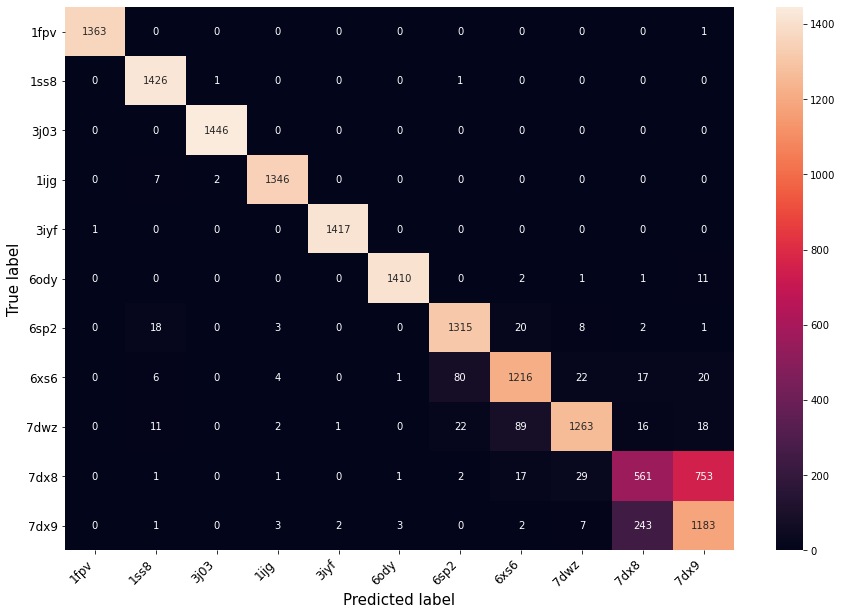

In [85]:
import pandas as pd
import seaborn as sns

nb_classes = 11
confusion_matrix = np.zeros((nb_classes, nb_classes))

for i, (inputs, count_labels, particle_labels) in enumerate(test_dataloader):
    inputs = inputs.to(device)
    _, y2 = model(inputs)
    y2 = torch.argmax(y2, dim=-1).to('cpu').numpy().tolist()
    for t, p in zip(particle_labels, y2):
        confusion_matrix[t, p] += 1

plt.figure(figsize=(15,10))

class_names = list(particle2idx.keys())
df_cm = pd.DataFrame(confusion_matrix, index=class_names, columns=class_names).astype(int)
heatmap = sns.heatmap(df_cm, annot=True, fmt="d")

heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right',fontsize=12)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right',fontsize=12)
plt.ylabel('True label', fontsize=15)
plt.xlabel('Predicted label', fontsize=15)

# Train

In [69]:
def train(args, model, optimizer, loss_fn):
    """""
    Train the network on the training data
    """

    EPOCH = args.epoches

    train_dataloader, valid_dataloader, test_dataloader = get_dataloaders(args, 
                                                                          PARTICLES, 
                                                                          PARTICLES,
                                                                          test_diff_particle=False)
    step = 0

    train_loss_values = []
    train_accuracies = {
        'Total': [],
        'Count': [],
        'Particle': []
    }
    valid_loss_values = []
    valid_accuracies = {
        'Total': [],
        'Count': [],
        'Particle': []
    }
    for epoch in range(EPOCH):
        epoch_train_loss = 0.0
        with tqdm(total=len(train_dataloader)) as t: 
            for i, (inputs, count_labels, particle_labels) in enumerate(train_dataloader):
                step += 1
                model.train()

                inputs = inputs.to(device)
                
                if not args.multi_output:
                    outputs = model(inputs)
                    loss = loss_fn(outputs, count_labels.squeeze(0).to(device))
                else:
                    y1, y2 = model(inputs)
                    loss1 = loss_fn(y1, count_labels.squeeze(0).to(device))
                    loss2 = loss_fn(y2, particle_labels.squeeze(0).to(device))
                    loss = 4 * loss1 + loss2
                
                optimizer.zero_grad()
                loss.backward(retain_graph=True)
                optimizer.step()

                cost = loss.item()
                
                epoch_train_loss = cost
                
                t.set_postfix(train_loss='{:05.3f}'.format(cost))
                t.update()
                
                # torch.cuda.empty_cache()
        
        if epoch % args.evaluate_every == 0:
            valid_accuracy, valid_count_accuracy, valid_particle_accuracy, valid_loss = evaluate(model, criterion, valid_dataloader)
            valid_accuracies['Total'].append(valid_accuracy)
            valid_accuracies['Count'].append(valid_count_accuracy)
            valid_accuracies['Particle'].append(valid_particle_accuracy)
            valid_loss_values.append(valid_loss)
            
            train_accuracy, train_count_accuracy, train_particle_accuracy, train_loss = evaluate(model, criterion, train_dataloader)
            train_accuracies['Total'].append(train_accuracy)
            train_accuracies['Count'].append(train_count_accuracy)
            train_accuracies['Particle'].append(train_particle_accuracy)
            train_loss_values.append(train_loss)
            
            print(f'Step {step}: valid loss={valid_loss}, \n valid accuracy={valid_accuracy}, \n valid count accuracy={valid_count_accuracy}, \n valid particle accuracy={valid_particle_accuracy}')
            print(f'Step {step}: train loss={train_loss}, \n train accuracy={train_accuracy}, \n train count accuracy={train_count_accuracy}, \n valid particle accuracy={train_particle_accuracy}')

            
    torch.save(model.state_dict(), args.ckpt_path)
    
    plot_loss(args, train_loss_values, 'train')
    plot_accuracies(args, train_accuracies, 'train')
    plot_loss(args, valid_loss_values, 'validation')
    plot_accuracies(args, valid_accuracies, 'validation')
    
    test_accuracy, test_count_accuracy, test_particle_accuracy, _ = evaluate(model, criterion, test_dataloader)
    print('Test accuracy: %f' % test_accuracy)
    print('Test count accuracy: %f' % test_count_accuracy)
    print('Test particle accuracy: %f' % test_particle_accuracy)

In [70]:
def plot_accuracies(args, accuracies, split):
    plt.figure(figsize=(6,5))
    plt.title(f"Total, count, and particle accuracies for {split} set")
    plt.plot(accuracies['Total'], label="Total", color='r')
    plt.plot(accuracies['Count'], label="Count", color='g')
    plt.plot(accuracies['Particle'], label="Particle", color='b')
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.savefig(f'{args.logdir}/{args.model}_{split}_accuracies_{dt.now()}.png')
    plt.show()

In [71]:
def plot_loss(args, loss_values, split):
    plt.figure(figsize=(6,5))
    plt.title(f"{split} loss")
    plt.plot(loss_values,label="train", color='b')
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.savefig(f'{args.logdir}/{args.model}_{split}_loss_{dt.now()}.png')
    plt.show()

# Run the pipeline

In [72]:
def load_model(args):
    if args.model == 'multi_output_cnn':
        num_particles = args.num_particles
        num_counts = args.num_counts
        hidden_dim = 8
        model = MultiOutputCNN(num_particles=num_particles, num_counts=num_counts, hidden_dim=hidden_dim).to(device)
    elif args.model == 'multi_output_resnet18':
        num_particles = args.num_particles
        num_counts = args.num_counts
        model = CustomResNet18Model(num_counts, num_particles).to(device)
    elif args.model == 'multi_output_vgg16':
        num_particles = args.num_particles
        num_counts = args.num_counts
        model = CustomVgg16Model(num_counts, num_particles).to(device)
    return model

In [73]:
PARTICLES = ['1fpv', '1ss8', '3j03', '1ijg', '3iyf', '6ody', '6sp2', '6xs6', '7dwz', '7dx8', '7dx9']
COUNTS = ['single', 'double', 'triple', 'quadruple']
LENGTH = 1000

In [75]:
args = {
    'model': 'multi_output_cnn', # multi_output_cnn || multi_output_resnet18 || multi_output_vgg16
    'root_dir': './data/thumbnail',
    'epoches': 20,
    'batch_size': 128,
    'shuffle': False,
    'num_workers': 1,
    'num_particles': 11,
    'num_counts': 4,
    'length': 1000,
    'evaluate_every': 1,
    'logdir': './logs',
    'multi_output': True
}
args = Namespace(**args)
args.ckpt_path = f'{args.logdir}/{args.model}_checkpoint.pth'

In [76]:
"""
Define loss function and optimizer

We will use the cross entropy loss and Adam optimizer
"""

# Create model
model = load_model(args)

# Define the cost function
criterion = nn.CrossEntropyLoss()

# Define the optimizer, learning rate 
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.001)

In [77]:
model

MultiOutputCNN(
  (conv1): Conv2d(1, 8, kernel_size=(2, 2), stride=(2, 2))
  (conv2): Conv2d(8, 16, kernel_size=(2, 2), stride=(2, 2))
  (conv3): Conv2d(16, 32, kernel_size=(2, 2), stride=(2, 2))
  (conv4): Conv2d(32, 64, kernel_size=(2, 2), stride=(2, 2))
  (conv5): Conv2d(64, 64, kernel_size=(2, 2), stride=(1, 1))
  (conv6): Conv2d(64, 64, kernel_size=(2, 2), stride=(1, 1))
  (conv7): Conv2d(64, 64, kernel_size=(2, 2), stride=(1, 1))
  (conv8): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1))
  (conv9): Conv2d(128, 128, kernel_size=(2, 2), stride=(1, 1))
  (dropout1): Dropout(p=0.25, inplace=False)
  (fc1): Linear(in_features=2048, out_features=4, bias=True)
  (fc2): Linear(in_features=2048, out_features=11, bias=True)
)

  0%|          | 0/422 [00:00<?, ?it/s]

77000


100%|██████████| 422/422 [00:37<00:00, 11.31it/s, train_loss=2.215]


{'1fpv': 1.0, '3j03': 0.9736456808199122, '1ijg': 0.749648382559775, '3iyf': 0.856353591160221, '6ody': 0.972972972972973, '6sp2': 0.7047477744807121, '6xs6': 0.13434903047091412, '7dwz': 0.6175243393602226, '7dx8': 0.33382789317507416, '7dx9': 0.5990853658536586}


  0%|          | 0/422 [00:00<?, ?it/s]

{'1fpv': 1.0, '3j03': 0.9673578320673373, '1ijg': 0.7235508715038508, '3iyf': 0.8647591601482092, '6ody': 0.981799379524302, '6sp2': 0.7069973785037306, '6xs6': 0.1254071661237785, '7dwz': 0.608973039720107, '7dx8': 0.34327756500705503, '7dx9': 0.5946938775510204}
Step 422: valid loss=1.87090323010429, 
 valid accuracy=62.44155844155844, 
 valid count accuracy=87.3116883116883, 
 valid particle accuracy=68.66233766233766
Step 422: train loss=1.8752531902202498, 
 train accuracy=61.75324675324675, 
 train count accuracy=87.08719851576994, 
 valid particle accuracy=67.97588126159555


100%|██████████| 422/422 [00:37<00:00, 11.30it/s, train_loss=1.921]


{'1fpv': 1.0, '3j03': 0.9780380673499268, '1ijg': 0.8143459915611815, '3iyf': 0.9682320441988951, '6ody': 0.981081081081081, '6sp2': 0.7344213649851632, '6xs6': 0.7520775623268698, '7dwz': 0.7746870653685675, '7dx8': 0.37833827893175076, '7dx9': 0.5640243902439024}


  0%|          | 0/422 [00:00<?, ?it/s]

{'1fpv': 0.9987881236113917, '3j03': 0.9677684253746663, '1ijg': 0.83664369679773, '3iyf': 0.9757101687937423, '6ody': 0.9894519131334023, '6sp2': 0.7265577737447066, '6xs6': 0.7361563517915309, '7dwz': 0.7954311586746244, '7dx8': 0.3690788147550897, '7dx9': 0.6018367346938776}
Step 844: valid loss=1.5070377891180946, 
 valid accuracy=72.57142857142857, 
 valid count accuracy=88.83116883116882, 
 valid particle accuracy=78.28571428571428
Step 844: train loss=1.4784709191152834, 
 train accuracy=72.860853432282, 
 train count accuracy=89.37105751391465, 
 valid particle accuracy=78.20964749536178


100%|██████████| 422/422 [00:37<00:00, 11.31it/s, train_loss=1.147]


{'1fpv': 1.0, '3j03': 0.9956076134699854, '1ijg': 0.9521800281293952, '3iyf': 0.9848066298342542, '6ody': 0.9932432432432432, '6sp2': 0.7477744807121661, '6xs6': 0.8587257617728532, '7dwz': 0.7246175243393602, '7dx8': 0.38724035608308605, '7dx9': 0.5426829268292683}


  0%|          | 0/422 [00:00<?, ?it/s]

{'1fpv': 1.0, '3j03': 0.9911722438924245, '1ijg': 0.9620997162545601, '3iyf': 0.9806504734458625, '6ody': 0.9952430196483971, '6sp2': 0.745714861867312, '6xs6': 0.8521986970684039, '7dwz': 0.7563284626466351, '7dx8': 0.43317879459786335, '7dx9': 0.5657142857142857}
Step 1266: valid loss=1.1662718436268509, 
 valid accuracy=79.1948051948052, 
 valid count accuracy=92.14285714285714, 
 valid particle accuracy=82.55844155844156
Step 1266: train loss=1.088461879693784, 
 train accuracy=79.78664192949907, 
 train count accuracy=92.57142857142857, 
 valid particle accuracy=83.10018552875695


100%|██████████| 422/422 [00:37<00:00, 11.24it/s, train_loss=0.906]


{'1fpv': 0.9547445255474453, '3j03': 1.0, '1ijg': 0.9690576652601969, '3iyf': 0.988950276243094, '6ody': 0.9905405405405405, '6sp2': 0.7789317507418397, '6xs6': 0.8670360110803325, '7dwz': 0.7399165507649513, '7dx8': 0.56973293768546, '7dx9': 0.37652439024390244}


  0%|          | 0/422 [00:00<?, ?it/s]

{'1fpv': 0.9767723692183398, '3j03': 0.9969205501950318, '1ijg': 0.9720308066477503, '3iyf': 0.9864141622066694, '6ody': 0.9975180972078593, '6sp2': 0.7803992740471869, '6xs6': 0.881514657980456, '7dwz': 0.7649722165054538, '7dx8': 0.6039105019149366, '7dx9': 0.36653061224489797}
Step 1688: valid loss=1.1411644664944196, 
 valid accuracy=79.31168831168831, 
 valid count accuracy=92.22077922077922, 
 valid particle accuracy=83.41558441558442
Step 1688: train loss=1.0296054082388562, 
 train accuracy=79.92949907235621, 
 train count accuracy=93.03339517625233, 
 valid particle accuracy=83.68274582560296


100%|██████████| 422/422 [00:37<00:00, 11.31it/s, train_loss=0.761]


{'1fpv': 1.0, '3j03': 0.9941434846266471, '1ijg': 0.9648382559774965, '3iyf': 0.9903314917127072, '6ody': 0.9918918918918919, '6sp2': 0.7477744807121661, '6xs6': 0.9127423822714681, '7dwz': 0.7649513212795549, '7dx8': 0.642433234421365, '7dx9': 0.35823170731707316}


  0%|          | 0/422 [00:00<?, ?it/s]

{'1fpv': 1.0, '3j03': 0.9928146171217409, '1ijg': 0.9718281313336036, '3iyf': 0.9798270893371758, '6ody': 0.997311271975181, '6sp2': 0.7374470659407139, '6xs6': 0.9228420195439739, '7dwz': 0.7857583864992796, '7dx8': 0.6536988510380971, '7dx9': 0.3314285714285714}
Step 2110: valid loss=0.8863031348732652, 
 valid accuracy=81.3896103896104, 
 valid count accuracy=94.35064935064935, 
 valid particle accuracy=84.12987012987013
Step 2110: train loss=0.7980662234198143, 
 train accuracy=81.3339517625232, 
 train count accuracy=95.46938775510205, 
 valid particle accuracy=83.57699443413729


100%|██████████| 422/422 [00:37<00:00, 11.26it/s, train_loss=0.503]


{'1fpv': 1.0, '3j03': 0.9985358711566618, '1ijg': 0.9985935302390999, '3iyf': 0.9917127071823204, '6ody': 0.9837837837837838, '6sp2': 0.8946587537091988, '6xs6': 0.8739612188365651, '7dwz': 0.7788595271210014, '7dx8': 0.526706231454006, '7dx9': 0.5152439024390244}


  0%|          | 0/422 [00:00<?, ?it/s]

{'1fpv': 0.9997980206018986, '3j03': 0.9997947033463355, '1ijg': 0.9977705715443859, '3iyf': 0.9965006175380815, '6ody': 0.9869700103412616, '6sp2': 0.9005847953216374, '6xs6': 0.882328990228013, '7dwz': 0.8042807161967483, '7dx8': 0.5565410199556541, '7dx9': 0.54}
Step 2532: valid loss=0.9037752395770589, 
 valid accuracy=83.31168831168831, 
 valid count accuracy=93.84415584415584, 
 valid particle accuracy=87.16883116883118
Step 2532: train loss=0.7769954147532371, 
 train accuracy=84.57142857142857, 
 train count accuracy=94.95732838589981, 
 valid particle accuracy=87.69944341372913


100%|██████████| 422/422 [00:37<00:00, 11.23it/s, train_loss=0.313]


{'1fpv': 0.9985401459854014, '3j03': 0.9985358711566618, '1ijg': 1.0, '3iyf': 0.994475138121547, '6ody': 0.9797297297297297, '6sp2': 0.887240356083086, '6xs6': 0.8614958448753463, '7dwz': 0.8915159944367177, '7dx8': 0.6735905044510386, '7dx9': 0.3978658536585366}


  0%|          | 0/422 [00:00<?, ?it/s]

{'1fpv': 0.9997980206018986, '3j03': 0.9997947033463355, '1ijg': 0.9967571949736522, '3iyf': 0.9971181556195965, '6ody': 0.9867631851085833, '6sp2': 0.9028029844726759, '6xs6': 0.8670602605863192, '7dwz': 0.9220004116073266, '7dx8': 0.7165893972989317, '7dx9': 0.3818367346938776}
Step 2954: valid loss=0.8619718869201473, 
 valid accuracy=84.85714285714285, 
 valid count accuracy=94.18181818181817, 
 valid particle accuracy=88.36363636363636
Step 2954: train loss=0.6869805400564348, 
 train accuracy=85.99628942486085, 
 train count accuracy=95.48794063079778, 
 valid particle accuracy=88.71985157699443


100%|██████████| 422/422 [00:37<00:00, 11.15it/s, train_loss=0.389]


{'1fpv': 1.0, '3j03': 1.0, '1ijg': 0.9943741209563994, '3iyf': 0.9986187845303868, '6ody': 0.9837837837837838, '6sp2': 0.7863501483679525, '6xs6': 0.909972299168975, '7dwz': 0.9040333796940194, '7dx8': 0.35756676557863504, '7dx9': 0.7637195121951219}


  0%|          | 0/422 [00:00<?, ?it/s]

{'1fpv': 1.0, '3j03': 1.0, '1ijg': 0.9943250912038913, '3iyf': 0.9995883079456567, '6ody': 0.9896587383660806, '6sp2': 0.7947166767493447, '6xs6': 0.9163273615635179, '7dwz': 0.921383000617411, '7dx8': 0.4077806893771417, '7dx9': 0.7916326530612245}
Step 3376: valid loss=0.7083600590952107, 
 valid accuracy=86.61038961038962, 
 valid count accuracy=95.98701298701299, 
 valid particle accuracy=88.42857142857142
Step 3376: train loss=0.5524202378828661, 
 train accuracy=87.46753246753246, 
 train count accuracy=96.86641929499072, 
 valid particle accuracy=88.98144712430427


100%|██████████| 422/422 [00:37<00:00, 11.34it/s, train_loss=0.392]


{'1fpv': 1.0, '3j03': 0.9985358711566618, '1ijg': 0.9985935302390999, '3iyf': 0.994475138121547, '6ody': 0.9891891891891892, '6sp2': 0.8620178041543026, '6xs6': 0.9362880886426593, '7dwz': 0.8998609179415855, '7dx8': 0.43768545994065283, '7dx9': 0.6707317073170732}


  0%|          | 0/422 [00:00<?, ?it/s]

{'1fpv': 1.0, '3j03': 0.9997947033463355, '1ijg': 0.9981759221726794, '3iyf': 0.9960889254837382, '6ody': 0.9956566701137539, '6sp2': 0.8800161322847349, '6xs6': 0.9436074918566775, '7dwz': 0.9318789874459765, '7dx8': 0.47510582543841967, '7dx9': 0.693469387755102}
Step 3798: valid loss=0.5620126567903112, 
 valid accuracy=87.77922077922078, 
 valid count accuracy=96.67532467532467, 
 valid particle accuracy=89.20779220779221
Step 3798: train loss=0.4358970225607685, 
 train accuracy=88.97588126159555, 
 train count accuracy=97.7773654916512, 
 valid particle accuracy=89.94805194805194


100%|██████████| 422/422 [00:37<00:00, 11.19it/s, train_loss=0.265]


{'1fpv': 0.9985401459854014, '3j03': 1.0, '1ijg': 1.0, '3iyf': 1.0, '6ody': 0.9918918918918919, '6sp2': 0.8026706231454006, '6xs6': 0.9168975069252078, '7dwz': 0.9109874826147427, '7dx8': 0.20474777448071216, '7dx9': 0.926829268292683}


  0%|          | 0/422 [00:00<?, ?it/s]

{'1fpv': 0.9997980206018986, '3j03': 1.0, '1ijg': 0.9985812728009729, '3iyf': 0.9995883079456567, '6ody': 0.9956566701137539, '6sp2': 0.8197217180883243, '6xs6': 0.9222312703583062, '7dwz': 0.9471084585305618, '7dx8': 0.22193106228582948, '7dx9': 0.9326530612244898}
Step 4220: valid loss=0.6052960559237198, 
 valid accuracy=87.64935064935065, 
 valid count accuracy=96.72727272727273, 
 valid particle accuracy=88.94805194805194
Step 4220: train loss=0.45890965455286736, 
 train accuracy=88.4452690166976, 
 train count accuracy=97.88311688311688, 
 valid particle accuracy=89.28014842300557


100%|██████████| 422/422 [00:40<00:00, 10.52it/s, train_loss=0.155]


{'1fpv': 0.9985401459854014, '3j03': 1.0, '1ijg': 0.9971870604781997, '3iyf': 0.9986187845303868, '6ody': 0.9891891891891892, '6sp2': 0.8605341246290801, '6xs6': 0.9113573407202216, '7dwz': 0.9165507649513213, '7dx8': 0.3991097922848665, '7dx9': 0.7301829268292683}


  0%|          | 0/422 [00:00<?, ?it/s]

{'1fpv': 0.9997980206018986, '3j03': 0.9997947033463355, '1ijg': 0.9975678962302391, '3iyf': 0.9997941539728283, '6ody': 0.9952430196483971, '6sp2': 0.8723532970356926, '6xs6': 0.9216205211726385, '7dwz': 0.9543115867462441, '7dx8': 0.4745011086474501, '7dx9': 0.756734693877551}
Step 4642: valid loss=0.6451490613036468, 
 valid accuracy=87.79220779220779, 
 valid count accuracy=96.50649350649351, 
 valid particle accuracy=89.36363636363637
Step 4642: train loss=0.4573069060314005, 
 train accuracy=89.36734693877551, 
 train count accuracy=97.73469387755101, 
 valid particle accuracy=90.42300556586271


100%|██████████| 422/422 [00:41<00:00, 10.11it/s, train_loss=0.282]


{'1fpv': 1.0, '3j03': 1.0, '1ijg': 0.9985935302390999, '3iyf': 0.9986187845303868, '6ody': 0.9864864864864865, '6sp2': 0.8635014836795252, '6xs6': 0.9182825484764543, '7dwz': 0.9026425591098748, '7dx8': 0.37091988130563797, '7dx9': 0.7987804878048781}


  0%|          | 0/422 [00:00<?, ?it/s]

{'1fpv': 1.0, '3j03': 1.0, '1ijg': 0.9989866234292664, '3iyf': 0.999382461918485, '6ody': 0.9923474663908997, '6sp2': 0.8779995966928816, '6xs6': 0.9427931596091205, '7dwz': 0.9370240790286067, '7dx8': 0.3991130820399113, '7dx9': 0.8179591836734694}
Step 5064: valid loss=0.5633345013026332, 
 valid accuracy=88.2987012987013, 
 valid count accuracy=96.84415584415585, 
 valid particle accuracy=89.72727272727272
Step 5064: train loss=0.39322541271870454, 
 train accuracy=89.39888682745826, 
 train count accuracy=97.97217068645641, 
 valid particle accuracy=90.51205936920222


100%|██████████| 422/422 [00:37<00:00, 11.14it/s, train_loss=0.298]


{'1fpv': 0.9985401459854014, '3j03': 1.0, '1ijg': 0.9887482419127989, '3iyf': 0.9986187845303868, '6ody': 0.9878378378378379, '6sp2': 0.7344213649851632, '6xs6': 0.909972299168975, '7dwz': 0.9568845618915159, '7dx8': 0.29821958456973297, '7dx9': 0.850609756097561}


  0%|          | 0/422 [00:00<?, ?it/s]

{'1fpv': 0.9997980206018986, '3j03': 1.0, '1ijg': 0.9933117146331577, '3iyf': 0.9995883079456567, '6ody': 0.9960703205791106, '6sp2': 0.7485380116959064, '6xs6': 0.9189739413680782, '7dwz': 0.9823008849557522, '7dx8': 0.3497278774440637, '7dx9': 0.8812244897959184}
Step 5486: valid loss=0.5692986656652123, 
 valid accuracy=87.6883116883117, 
 valid count accuracy=97.27272727272728, 
 valid particle accuracy=88.58441558441558
Step 5486: train loss=0.40498715017202763, 
 train accuracy=88.82745825602969, 
 train count accuracy=98.39146567717997, 
 valid particle accuracy=89.41558441558442


100%|██████████| 422/422 [00:37<00:00, 11.30it/s, train_loss=0.174]


{'1fpv': 1.0, '3j03': 1.0, '1ijg': 0.9985935302390999, '3iyf': 0.9958563535911602, '6ody': 0.9878378378378379, '6sp2': 0.9080118694362018, '6xs6': 0.9445983379501385, '7dwz': 0.8873435326842837, '7dx8': 0.456973293768546, '7dx9': 0.7682926829268293}


  0%|          | 0/422 [00:00<?, ?it/s]

{'1fpv': 1.0, '3j03': 1.0, '1ijg': 0.9973652209160924, '3iyf': 0.9973240016467683, '6ody': 0.9950361944157187, '6sp2': 0.9270014115749143, '6xs6': 0.9639657980456026, '7dwz': 0.9300267544762296, '7dx8': 0.5230800241886716, '7dx9': 0.8077551020408164}
Step 5908: valid loss=0.46437076021169055, 
 valid accuracy=89.50649350649351, 
 valid count accuracy=97.4935064935065, 
 valid particle accuracy=90.5844155844156
Step 5908: train loss=0.29500921445256495, 
 train accuracy=91.45269016697588, 
 train count accuracy=98.87384044526901, 
 valid particle accuracy=92.04823747680891


100%|██████████| 422/422 [00:37<00:00, 11.33it/s, train_loss=0.155]


{'1fpv': 0.9985401459854014, '3j03': 0.9985358711566618, '1ijg': 0.9957805907172996, '3iyf': 1.0, '6ody': 0.9932432432432432, '6sp2': 0.8560830860534124, '6xs6': 0.9390581717451524, '7dwz': 0.9290681502086231, '7dx8': 0.5519287833827893, '7dx9': 0.6265243902439024}


  0%|          | 0/422 [00:00<?, ?it/s]

{'1fpv': 1.0, '3j03': 0.9997947033463355, '1ijg': 0.9983785974868261, '3iyf': 1.0, '6ody': 0.9979317476732161, '6sp2': 0.8707400685622101, '6xs6': 0.9629478827361564, '7dwz': 0.971187487137271, '7dx8': 0.6331384801451321, '7dx9': 0.676734693877551}
Step 6330: valid loss=0.45869735579510207, 
 valid accuracy=89.31168831168831, 
 valid count accuracy=97.55844155844156, 
 valid particle accuracy=90.15584415584415
Step 6330: train loss=0.30212201562741003, 
 train accuracy=91.26901669758813, 
 train count accuracy=98.77179962894249, 
 valid particle accuracy=91.78849721706864


100%|██████████| 422/422 [00:37<00:00, 11.36it/s, train_loss=0.251]


{'1fpv': 0.9985401459854014, '3j03': 1.0, '1ijg': 0.9985935302390999, '3iyf': 1.0, '6ody': 0.9837837837837838, '6sp2': 0.8976261127596439, '6xs6': 0.9362880886426593, '7dwz': 0.9193324061196105, '7dx8': 0.29821958456973297, '7dx9': 0.9085365853658537}


  0%|          | 0/422 [00:00<?, ?it/s]

{'1fpv': 0.9997980206018986, '3j03': 1.0, '1ijg': 0.9979732468585326, '3iyf': 1.0, '6ody': 0.9875904860392968, '6sp2': 0.9239766081871345, '6xs6': 0.9617263843648208, '7dwz': 0.9456678328874254, '7dx8': 0.3692803870187462, '7dx9': 0.9214285714285714}
Step 6752: valid loss=0.5102318566842158, 
 valid accuracy=89.40259740259741, 
 valid count accuracy=97.42857142857143, 
 valid particle accuracy=90.62337662337663
Step 6752: train loss=0.3159695535664275, 
 train accuracy=91.07421150278293, 
 train count accuracy=98.63265306122449, 
 valid particle accuracy=91.80705009276437


100%|██████████| 422/422 [00:37<00:00, 11.31it/s, train_loss=0.142]


{'1fpv': 0.9985401459854014, '3j03': 1.0, '1ijg': 1.0, '3iyf': 1.0, '6ody': 0.9945945945945946, '6sp2': 0.9198813056379822, '6xs6': 0.9127423822714681, '7dwz': 0.8873435326842837, '7dx8': 0.29673590504451036, '7dx9': 0.8917682926829268}


  0%|          | 0/422 [00:00<?, ?it/s]

{'1fpv': 1.0, '3j03': 1.0, '1ijg': 0.9995946493717065, '3iyf': 0.9995883079456567, '6ody': 0.9991726990692864, '6sp2': 0.946965113934261, '6xs6': 0.9364820846905537, '7dwz': 0.9339370240790286, '7dx8': 0.38681717395686355, '7dx9': 0.9344897959183673}
Step 7174: valid loss=0.6201539464050629, 
 valid accuracy=88.59740259740259, 
 valid count accuracy=96.67532467532467, 
 valid particle accuracy=90.25974025974025
Step 7174: train loss=0.3764686153989762, 
 train accuracy=90.96660482374767, 
 train count accuracy=98.0964749536178, 
 valid particle accuracy=92.05751391465678


100%|██████████| 422/422 [00:37<00:00, 11.25it/s, train_loss=0.150]


{'1fpv': 0.9985401459854014, '3j03': 0.9985358711566618, '1ijg': 0.9971870604781997, '3iyf': 0.994475138121547, '6ody': 0.9824324324324324, '6sp2': 0.9258160237388724, '6xs6': 0.8933518005540166, '7dwz': 0.9652294853963839, '7dx8': 0.3724035608308605, '7dx9': 0.823170731707317}


  0%|          | 0/422 [00:00<?, ?it/s]

{'1fpv': 1.0, '3j03': 1.0, '1ijg': 0.9981759221726794, '3iyf': 0.9983532317826266, '6ody': 0.9898655635987591, '6sp2': 0.9536196813873765, '6xs6': 0.9232491856677525, '7dwz': 0.9810660629759209, '7dx8': 0.43761338439830677, '7dx9': 0.8528571428571429}
Step 7596: valid loss=0.6222526228330174, 
 valid accuracy=88.93506493506493, 
 valid count accuracy=96.57142857142857, 
 valid particle accuracy=90.74025974025975
Step 7596: train loss=0.36509352204857737, 
 train accuracy=90.92022263450835, 
 train count accuracy=98.08534322820037, 
 valid particle accuracy=92.04638218923932


100%|██████████| 422/422 [00:37<00:00, 11.33it/s, train_loss=0.110]


{'1fpv': 0.9985401459854014, '3j03': 1.0, '1ijg': 0.9985935302390999, '3iyf': 0.9986187845303868, '6ody': 0.9932432432432432, '6sp2': 0.9347181008902077, '6xs6': 0.8822714681440443, '7dwz': 0.9388038942976356, '7dx8': 0.4094955489614243, '7dx9': 0.8246951219512195}


  0%|          | 0/422 [00:00<?, ?it/s]

{'1fpv': 1.0, '3j03': 1.0, '1ijg': 1.0, '3iyf': 0.9997941539728283, '6ody': 0.9966907962771459, '6sp2': 0.9566444847751563, '6xs6': 0.9169381107491856, '7dwz': 0.9648075735748096, '7dx8': 0.4869985889941544, '7dx9': 0.863265306122449}
Step 8018: valid loss=0.564615761647459, 
 valid accuracy=89.49350649350649, 
 valid count accuracy=96.97402597402598, 
 valid particle accuracy=90.8051948051948
Step 8018: train loss=0.32229722562682994, 
 train accuracy=91.69016697588125, 
 train count accuracy=98.5213358070501, 
 valid particle accuracy=92.43228200371057


100%|██████████| 422/422 [00:37<00:00, 11.21it/s, train_loss=0.104]


{'1fpv': 1.0, '3j03': 1.0, '1ijg': 0.9957805907172996, '3iyf': 1.0, '6ody': 0.9878378378378379, '6sp2': 0.9658753709198813, '6xs6': 0.9016620498614959, '7dwz': 0.8901251738525731, '7dx8': 0.38130563798219586, '7dx9': 0.8536585365853658}
{'1fpv': 0.9997980206018986, '3j03': 1.0, '1ijg': 0.9977705715443859, '3iyf': 0.999382461918485, '6ody': 0.99358841778697, '6sp2': 0.9749949586610204, '6xs6': 0.935871335504886, '7dwz': 0.9370240790286067, '7dx8': 0.46825236847409796, '7dx9': 0.8761224489795918}
Step 8440: valid loss=0.6877118071816006, 
 valid accuracy=88.57142857142857, 
 valid count accuracy=96.06493506493507, 
 valid particle accuracy=90.9090909090909
Step 8440: train loss=0.439230005543732, 
 train accuracy=90.8051948051948, 
 train count accuracy=97.53617810760667, 
 valid particle accuracy=92.5064935064935


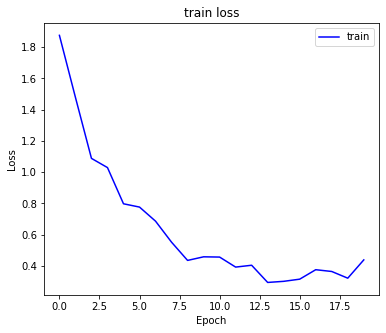

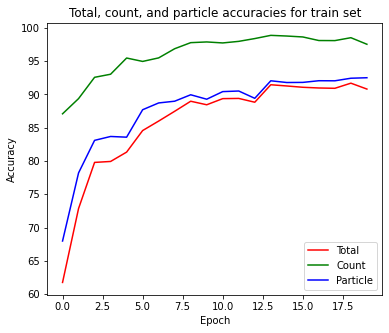

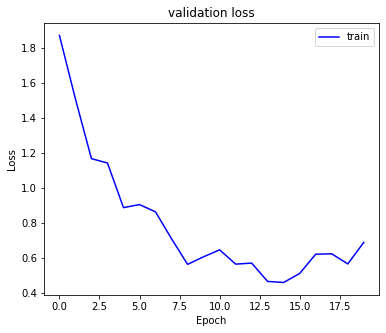

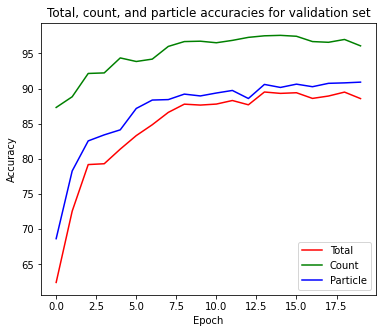

{'1fpv': 1.0, '3j03': 1.0, '1ijg': 0.996309963099631, '3iyf': 0.998589562764457, '6ody': 0.9859649122807017, '6sp2': 0.9575713240673006, '6xs6': 0.8923865300146413, '7dwz': 0.890295358649789, '7dx8': 0.4380952380952381, '7dx9': 0.832409972299169}
Test accuracy: 88.616883
Test count accuracy: 95.889610
Test particle accuracy: 90.922078


In [78]:
train(args, model, optimizer, criterion)

In [36]:
summary(model, input_size=(1, 128, 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 64, 64]              40
            Conv2d-2           [-1, 16, 32, 32]             528
            Conv2d-3           [-1, 32, 16, 16]           2,080
            Conv2d-4             [-1, 64, 8, 8]           8,256
            Conv2d-5             [-1, 64, 7, 7]          16,448
            Conv2d-6             [-1, 64, 6, 6]          16,448
            Conv2d-7             [-1, 64, 5, 5]          16,448
            Conv2d-8            [-1, 128, 5, 5]           8,320
            Conv2d-9            [-1, 128, 4, 4]          65,664
          Dropout-10            [-1, 128, 4, 4]               0
           Linear-11                    [-1, 4]           8,196
           Conv2d-12           [-1, 32, 16, 16]           2,080
           Conv2d-13             [-1, 64, 8, 8]           8,256
           Conv2d-14             [-1, 6